Mounted at /content/drive
📂 모델 로드 시도 중... 경로: /content/drive/MyDrive/toefl_model
   ↳ 저장된 모델 읽기 시도...


The tokenizer you are loading from '/content/drive/MyDrive/toefl_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e.  This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


✅ 저장된 모델 로드 성공! (Fine-tuned Model)

✅ 'test_dataset.csv' 파일을 찾았습니다.
테스트 데이터 개수: 6개

🚀 AI 채점 시작... (잠시만 기다려주세요)


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]



📊 [Final Evaluation Report]
                       Metric    Value
                          MSE 339.8239
               RMSE (낮을수록 좋음)  18.4343
Pearson Correlation (높을수록 좋음)  -0.7380


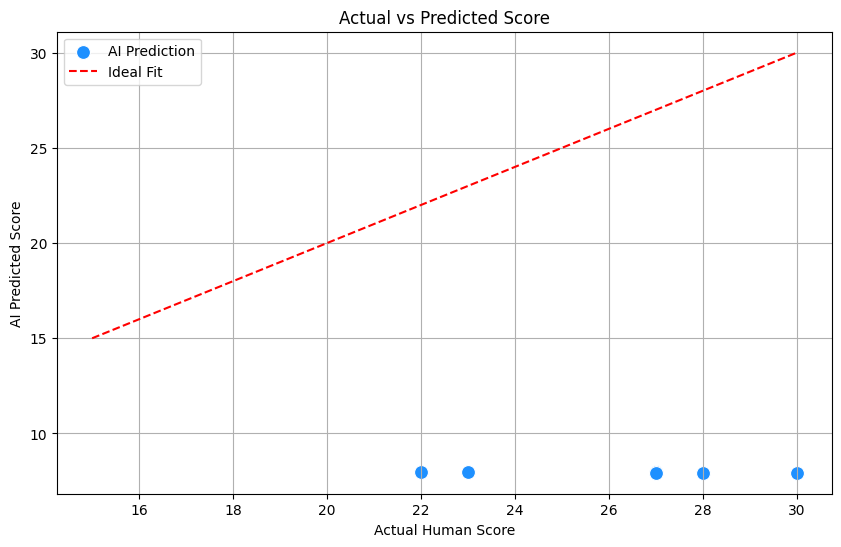


✅ 평가 완료! 'evaluation_plot.png'가 저장되었습니다.

[샘플 데이터 확인]
   score  predicted_score       Diff
0     23         7.950509  15.049491
1     27         7.953035  19.046965
2     30         7.937124  22.062876
3     27         7.939056  19.060944
4     28         7.943991  20.056009


In [1]:
# 1. 환경 설정 및 라이브러리 설치
# !pip install transformers pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import mean_squared_error
from google.colab import drive, files
import os

# ==========================================
# 1. 모델 불러오기 (안전장치 포함)
# ==========================================
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/toefl_model"

print(f"📂 모델 로드 시도 중... 경로: {model_path}")

# GPU 확인
device = 0 if torch.cuda.is_available() else -1

try:
    # 1차 시도: 저장된 내 모델 불러오기
    print("   ↳ 저장된 모델 읽기 시도...")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # [핵심 수정] function_to_apply="none" 추가!
    # -> 이걸 넣어야 0.999가 아니라 실제 점수(예: 25.4)가 나옵니다.
    scorer = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, function_to_apply="none")
    print("✅ 저장된 모델 로드 성공! (Fine-tuned Model)")

except Exception as e:
    print(f"\n⚠️ 저장된 모델 로드 실패: {e}")
    print("🚨 비상 모드: 기본 모델을 사용합니다.")

    base_model_name = "microsoft/deberta-v3-small"
    model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=1)
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    # 여기도 수정
    scorer = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, function_to_apply="none")
    print("✅ 기본 모델 로드 완료 (Base Model)")

# ==========================================
# 2. 테스트 데이터셋 로드
# ==========================================
file_name = "test_dataset.csv"

# 파일이 없으면 업로드 버튼 표시
if not os.path.exists(file_name):
    print(f"\n⚠️ '{file_name}' 파일이 없습니다. 아래 버튼으로 업로드해주세요.")
    uploaded = files.upload()
    for fn in uploaded.keys():
        if "csv" in fn:
            file_name = fn
            break
else:
    print(f"\n✅ '{file_name}' 파일을 찾았습니다.")

# 데이터 로드
try:
    test_df = pd.read_csv(file_name)
    print(f"테스트 데이터 개수: {len(test_df)}개")
except Exception as e:
    print(f"❌ 데이터 로드 실패: {e}")
    test_df = pd.DataFrame()

# ==========================================
# 3. 추론 및 평가 진행
# ==========================================
if not test_df.empty:
    print("\n🚀 AI 채점 시작... (잠시만 기다려주세요)")

    predictions = []
    # 진행바
    try:
        from tqdm import tqdm
        iterator = tqdm(test_df['essay_text'])
    except ImportError:
        iterator = test_df['essay_text']

    for text in iterator:
        # 모델 추론
        output = scorer(text, truncation=True, max_length=512)
        score = output[0]['score']
        predictions.append(score)

    test_df['predicted_score'] = predictions

    # ==========================================
    # 4. 결과 리포트 (표 출력)
    # ==========================================
    mse = mean_squared_error(test_df['score'], test_df['predicted_score'])
    rmse = np.sqrt(mse)
    pearson_corr = test_df['score'].corr(test_df['predicted_score'])

    metrics_data = {
        "Metric": ["MSE", "RMSE (낮을수록 좋음)", "Pearson Correlation (높을수록 좋음)"],
        "Value": [f"{mse:.4f}", f"{rmse:.4f}", f"{pearson_corr:.4f}"]
    }
    metrics_df = pd.DataFrame(metrics_data)

    print("\n" + "="*40)
    print("📊 [Final Evaluation Report]")
    print("="*40)
    print(metrics_df.to_string(index=False))
    print("="*40)

    # ==========================================
    # 5. 시각화 (그래프 저장)
    # ==========================================
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='score', y='predicted_score', data=test_df, color='dodgerblue', s=100, label='AI Prediction')

    # 기준선
    plt.plot([15, 30], [15, 30], 'r--', label='Ideal Fit')

    plt.title('Actual vs Predicted Score')
    plt.xlabel('Actual Human Score')
    plt.ylabel('AI Predicted Score')
    plt.legend()
    plt.grid(True)
    plt.savefig("evaluation_plot.png")
    plt.show()

    print("\n✅ 평가 완료! 'evaluation_plot.png'가 저장되었습니다.")

    # 샘플 출력
    print("\n[샘플 데이터 확인]")
    display_df = test_df[['score', 'predicted_score']].copy()
    display_df['Diff'] = abs(display_df['score'] - display_df['predicted_score'])
    print(display_df.head())

else:
    print("❌ 데이터가 없어서 평가를 진행할 수 없습니다.")